# Предсказание рейтинга поста по его параметрам

На сайте имеется лента постов, которую читают пользователи. За каждый пост пользователи могут голосовать: поставить ему плюс или минус. Рейтинг поста - это разность между количеством плюсов и минусов.

Каждый пост описывается некоторым набором параметров (время публикации, длина, тематические теги и т.п.)

Задача состоит в том, чтобы предсказать ожидаемый финальный рейтинг этого поста.


На примере этой задачи мы с вами познакомимся с Tensorflow + Keras и научимся строить простейшие модели нейросетей.

Сперва немного познакомимся с датасетом, с которым нам предстоит работать:

In [1]:
import pandas as pd
import numpy as np
import math
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # чтобы далее tensorflow не задействовал видеокарту

In [2]:
df = pd.read_csv('posts_df.csv')

In [3]:
df.shape

(262577, 8)

In [4]:
df.head()

,time,tags,nsfw,my,images,videos,text_len,rating
0,1569877228,"Творчество детское, Рисунок, Детский сад, Детс...",0,1,2,0,135,683
1,1569877232,"Собака, Было-Стало, {#73#}",0,1,1,0,113,480
2,1569877241,"Дерево, Поле, Фотография",0,0,1,0,0,301
3,1569877249,"Военторг, Из сети, Продукты, Длиннопост",0,0,4,0,0,425
4,1569877259,"Mortal Kombat 11, Тизер, Текст, Геймеры, Новос...",0,0,1,0,726,617


`time` - время публикации поста в формате unix timestamp

`tags` - тематические теги поста

`nsfw` - относится ли пост к тематике 18+

`my` - является ли пост оригинальным авторским

`images` - количество картинок в посте

`videos` - количество видео в посте

`text_len` - длина текста в посте

`rating` - финальный рейтинг поста (целевая переменная)

Давайте из столбца `time` вытащим сведения о том, в какое время суток был опубликован пост. 

Но если мы будем кодировать время суток как просто количество секунд, прошедшее с определённого момента, то мы не сможем учесть тот факт, что минимальные и максимальные моменты времени достаточно близки друг к другу. Так, например, время 23:59 и 00:01 - практически одно и то же, но на нашей шкале они будут максимально далеко друг от друга. 

Для того, чтобы избежать такого эффекта, представим время как угловую координату на окружности (меняющуюся от 0 до 2pi) и закодируем его в виде двух переменных: синуса и косинуса этого угла. В таком случае близкие друг к другу моменты времени будут иметь близкие значения во входных данных.

In [5]:
# получим количество секунд, прошедшее с начала суток
df['time'] = df['time'] % (60*60*24)

# и отнормируем все значения на 2pi
df['time'] = (df['time'] / df['time'].max()) * 2*math.pi

In [6]:
# добавим колонки с синусом и косинусом нашего времени
tsin_list = []
tcos_list = []
for row in df['time']:
    tsin_list.append(math.sin(row))
    tcos_list.append(math.cos(row))

df['tsin'] = tsin_list
df['tcos'] = tcos_list

In [7]:
df = df.drop(columns=['time'])

In [8]:
df.head()

,tags,nsfw,my,images,videos,text_len,rating,tsin,tcos
0,"Творчество детское, Рисунок, Детский сад, Детс...",0,1,2,0,135,683,-0.705620,0.708590
1,"Собака, Было-Стало, {#73#}",0,1,1,0,113,480,-0.705414,0.708795
2,"Дерево, Поле, Фотография",0,0,1,0,0,301,-0.704950,0.709257
3,"Военторг, Из сети, Продукты, Длиннопост",0,0,4,0,0,425,-0.704537,0.709667
4,"Mortal Kombat 11, Тизер, Текст, Геймеры, Новос...",0,0,1,0,726,617,-0.704021,0.710179


Теперь разберёмся с тегами. Их достаточно много разных.

Среди них встречаются теги вида `{#73#}` - это теги сообществ. Т.к. они достаточно редки, давайте уберём их, но добавим в наш датасет дополнительный признак - был ли пост опубликован в сообществе.

In [9]:
#сделаем из строк списки с тегами
df['tags'] = df['tags'].apply(lambda x: x.split(', '))

In [10]:
in_comm_list = []  # новый столбец в нашем датасете, "был ли пост опубликован в сообществе"

# удалим теги, начинающиеся и заканчивающиеся фигурной скобкой, 
# при этом запомнив, что пост был в сообществе
for row in df['tags']:
    is_in_comm = 0
    for tag in row:
        if tag[0] == '{' and tag[-1] == '}':
            row.remove(tag)
            is_in_comm = 1
    in_comm_list.append(is_in_comm)

df['in_comm'] = in_comm_list

Теперь давайте посмотрим, сколько вообще у нас имеется разных тегов:

In [11]:
# воспользуемся множествами, чтобы каждый тег учесть только в одном экземпляре
tags_set = set()

# добавим все имеющиеся теги в множество
for row in df['tags']:
    for tag in row:
        tags_set.add(tag)

print(f"Количество используемых тегов: {len(tags_set)}")

Количество используемых тегов: 63385


Тегов много, но многие из них используются достаточно редко и вряд ли дадут нам много информации. Поэтому давайте при помощи One-Hot Encoding закодируем 50 самых популярных тегов, а если никакие из них не встречаются в посте, укажем это в дополнительном столбце `other`.

In [12]:
# создадим словарь для подсчёта того, 
# сколько раз каждый тег встречается в нашем датасете
tags_dict = {tag: 0 for tag in tags_set}

for row in df['tags']:
    for tag in row:
        tags_dict[tag] += 1

In [13]:
# преобразуем словарь в список пар (тег, кол-во вхождений)
# и отсортируем его по убыванию числа вхождений тега
tags_list = list(tags_dict.items())
tags_list.sort(key=lambda x: x[1], reverse=True)

In [14]:
# 10 самых популярных тегов:
tags_list[:10]

[('Длиннопост', 75128),
 ('Текст', 59256),
 ('Видео', 34107),
 ('Юмор', 14957),
 ('Кот', 13512),
 ('Фотография', 10869),
 ('Мат', 8662),
 ('Скриншот', 8251),
 ('Арт', 7585),
 ('Комиксы', 6446)]

In [15]:
# 10 самых непопулярных тегов:
tags_list[-10:]

[('Крис Рок', 1),
 ('Шкаф-Мастерская', 1),
 ('Ла-Манш', 1),
 ('Каттелан', 1),
 ('Gowther', 1),
 ('На ощупь', 1),
 ('Рапан', 1),
 ('Индексация пенсий', 1),
 ('Выпады', 1),
 ('Скинул вес', 1)]

In [16]:
# будем использовать только 50 самых популярных тегов
tags2use = 50
popular_tags = [t[0] for t in tags_list[:tags2use]]

In [17]:
# создадим в датафрейме колонку под каждый тег, 
# где отметим, встречался ли этот тег в посте
for tag in popular_tags:
    df[tag] = df['tags'].apply(lambda x: int(tag in x))

In [18]:
# в столбце `other` сделаем отметку, 
# если пост не описывается популярными тегами 
# (т.е. в столбцах с тегами стоят одни нули)
df['other'] = df[popular_tags].sum(axis=1)
df['other'] = df['other'].apply(lambda x: int(x == 0))

In [19]:
df.head()

,tags,nsfw,my,images,videos,text_len,rating,tsin,tcos,in_comm,...,Своими руками,My Little Pony,Музыка,Мошенничество,Отношения,Стихи,Зима,СССР,Еда,other
0,"[Творчество детское, Рисунок, Детский сад, Дет...",0,1,2,0,135,683,-0.705620,0.708590,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Собака, Было-Стало]",0,1,1,0,113,480,-0.705414,0.708795,1,...,0,0,0,0,0,0,0,0,0,0
2,"[Дерево, Поле, Фотография]",0,0,1,0,0,301,-0.704950,0.709257,0,...,0,0,0,0,0,0,0,0,0,0
3,"[Военторг, Из сети, Продукты, Длиннопост]",0,0,4,0,0,425,-0.704537,0.709667,0,...,0,0,0,0,0,0,0,0,0,0
4,"[Mortal Kombat 11, Тизер, Текст, Геймеры, Ново...",0,0,1,0,726,617,-0.704021,0.710179,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df[popular_tags + ['other']].mean()

Длиннопост                   0.286118
Текст                        0.225671
Видео                        0.129893
Юмор                         0.056962
Кот                          0.051459
Фотография                   0.041394
Мат                          0.032272
Скриншот                     0.031423
Арт                          0.028887
Комиксы                      0.024549
Аниме                        0.022454
История                      0.020272
Anime Art                    0.020268
Собака                       0.019362
Без рейтинга                 0.019122
Комментарии на Пикабу        0.018303
Политика                     0.017599
Новый Год                    0.017515
Дети                         0.017092
Рисунок                      0.016806
Картинка с текстом           0.016209
Новости                      0.016163
Девушки                      0.015782
Помощь                       0.015100
Россия                       0.014929
Котомафия                    0.014918
Работа      

In [21]:
df = df.drop(columns=['tags'])

In [22]:
# подготовим массивы входных и выходных данных
X = df.drop(columns=['rating']).to_numpy()
Y = df['rating'].to_numpy()

In [23]:
X.shape

(262577, 59)

In [24]:
Y.shape

(262577,)

Датасет подготовлен, теперь можно и натравить на него нейросеть!

In [25]:
import tensorflow as tf

Модуль `keras` является полноценной частью TF. С его помощью можно легко и быстро строить модели нейросетей. 

Существует несколько способов задать архитектуру нейросети в Keras. Самый простой из них (но и наименее гибкий) - последовательная структура: `tf.keras.models.Sequential`. С помощью последовательной модели можно задачать нейросеть, состоящую из последовательно соединённых друг с другом слоёв.

Среди всех слоёв нам сейчас нужен полносвязный слой: `tf.keras.layers.Dense`. Это обычный слой из нейронов, к каждому из которых присоединены все выходы с предыдущего слоя (полная связность).

In [26]:
# создадим последовательную модель при помощи Keras

model = tf.keras.models.Sequential([
    # в качестве аргумента необходимо указать список слоёв нейросети
    
    # в первом аргументе Dense-слоя указывается количество нейронов в нём
    tf.keras.layers.Dense(10,
                          # также в первом слое необходимо указать размерность данных, которые будут подаваться на вход
                          # в нашем случае это одномерный массив, так что просто указываем его длину в `input_shape`
                          input_shape=(X.shape[1],),
                          # функцию активации также берём готовую из Keras
                          activation=tf.keras.activations.relu,
                         ),
    
    # для некоторых популярных функций активации предусмотеры 
    # удобные строковые сокращения, например: 'relu', 'sigmoid', 'linear'
    # также при желании слою можно дать название
    tf.keras.layers.Dense(10, activation='relu', name='l2'),
    
    # для нашей задачи в качестве последнего слоя достаточно
    # использовать 1 нейрон с линейной функцией активации
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, name='out')
])

In [27]:
# посмотрим на структуру получившейся нейросети
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                600       
_________________________________________________________________
l2 (Dense)                   (None, 10)                110       
_________________________________________________________________
out (Dense)                  (None, 1)                 11        
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


В сводке отображается информация о слоях с теми именами, которые мы им дали.

Обратим внимание, что в столбце `Output Shape` указано 2 измерения, но первое значение пусто. Эта графа описывает формат данных, получающихся на выходе каждого слоя. Мы с вами знаем, что у полносвязного слоя с 10 нейронами должно быть 10 выходов, что и отражено во второй цифре. 

Однако на самом деле наша нейросеть может обрабатывать данные не только по одному вектору, но и сразу параллельно целыми "пачками" векторов, т.е. "батчами". Соответственно, если слой работает не с одним вектором, а сразу с батчем, то он и выдаст не один вектор, а целую матрицу из них. 

Под размер батча и зарезервирован первый аргумент. Но т.к. нейросеть ещё не знает, с какими данными ей предстоит работать, там стоит None. Хотя ей, в принципе, всё равно =)

В последнем столбце указано количество весов в слое. Обратите внимание, что весов несколько больше: так, например, последний слой из одного нейрона имеет 11 весов, хотя подсоединён к слою из 10 нейронов. Один дополнительный вес приходится на bias-нейрон, который неявно содержится в предыдущем слое.

При желании во время создания модели bias можно отключить, прописав в параметрах слоя `use_bias=False`, но делать это не рекомендуется.

In [28]:
# при желании мы можем посмотреть на веса в каждом слое
# например, в последнем слое это просто вектор-строка из 10 случайных чисел + нулевой bias:
model.layers[-1].get_weights()

[array([[ 0.2138719 ],
        [-0.6740933 ],
        [-0.17233282],
        [ 0.2870242 ],
        [ 0.44022638],
        [-0.6103617 ],
        [ 0.31063086],
        [ 0.16324818],
        [ 0.610529  ],
        [ 0.47640544]], dtype=float32),
 array([0.], dtype=float32)]

In [29]:
# а вот в предыдущем слое уже матрица весов
model.layers[-2].get_weights()

[array([[-0.368545  ,  0.1864711 , -0.09445062,  0.11372906,  0.17744154,
          0.26156622, -0.35232228, -0.3176524 ,  0.46075654,  0.1699897 ],
        [ 0.18791741, -0.06210116,  0.42114556, -0.44434515,  0.06492782,
         -0.44231138,  0.5364237 ,  0.04543197, -0.08943725, -0.47371736],
        [-0.4891815 ,  0.02476561,  0.30045944,  0.37883556, -0.37237173,
          0.12912482, -0.20946038, -0.40734717,  0.10282779,  0.11628169],
        [ 0.00655746, -0.06056115, -0.50220054,  0.29067218, -0.11144197,
         -0.4308905 , -0.25079265, -0.15814114,  0.51037896, -0.18517205],
        [-0.21220139,  0.12465495,  0.32452863,  0.36221558,  0.31498867,
         -0.26083744, -0.31774318, -0.31384984, -0.13859785,  0.44637227],
        [ 0.221605  , -0.43550047,  0.00833815, -0.3154357 ,  0.03713363,
          0.5346726 , -0.02407455, -0.0108577 ,  0.1659838 , -0.22927463],
        [ 0.13820112, -0.03614563, -0.09639284,  0.12334746, -0.09890077,
          0.39305335,  0.2492503

In [30]:
# в модели можно и удалять не нужные слои, присоединяя новые
# например, давайте удалим 2 последних слоя и переделаем модель
model.pop()
model.pop()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                600       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [31]:
# добавим 2 слоя
model.add(tf.keras.layers.Dense(1000, activation='relu', name='very_big_layer'))
model.add(tf.keras.layers.Dense(1, activation='relu', name='out'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                600       
_________________________________________________________________
very_big_layer (Dense)       (None, 1000)              11000     
_________________________________________________________________
out (Dense)                  (None, 1)                 1001      
Total params: 12,601
Trainable params: 12,601
Non-trainable params: 0
_________________________________________________________________


In [32]:
# для нашей задачи будем использовать чуть более глубокую архитектуру
# с тремя промежуточными слоями
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(60, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
])

In [33]:
# загрузим готовые веса
model.load_weights('weights.h5')

In [34]:
# посмотрим, например, на веса последнего слоя
model.layers[-1].get_weights()

[array([[-0.49175557],
        [-0.26270723],
        [ 0.5572973 ],
        [ 1.0313578 ],
        [-1.2322445 ],
        [ 0.17110786],
        [ 0.77133995],
        [-2.3742123 ],
        [ 1.0334668 ],
        [-0.4283009 ]], dtype=float32),
 array([4.3187566], dtype=float32)]

In [35]:
# чтобы посчитать значение нашей нейросети на каком-либо векторе,
# воспользуемся методом `predict`
Y_pred = model.predict(X)

In [36]:
Y_pred

array([[533.6503 ],
       [479.25253],
       [278.79514],
       ...,
       [486.67563],
       [470.54608],
       [582.6574 ]], dtype=float32)

In [37]:
for i in range(10):
    print(Y_pred[i], '\t', Y[i])

[533.6503] 	 683
[479.25253] 	 480
[278.79514] 	 301
[398.70383] 	 425
[522.4281] 	 617
[557.47284] 	 515
[205.00832] 	 219
[514.7047] 	 -11
[621.18054] 	 628
[292.87457] 	 349


In [38]:
# давайте посмотрим, насколько вообще совпадает распределение 
# полученных оценок с настоящими данными

import seaborn as sns

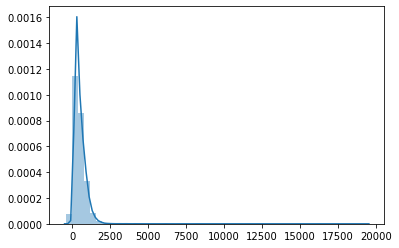

In [39]:
sns.distplot(Y)

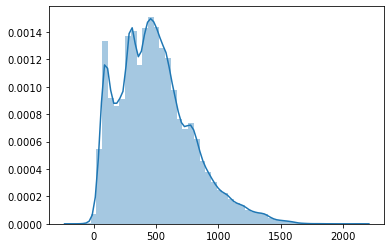

In [40]:
sns.distplot(Y_pred)

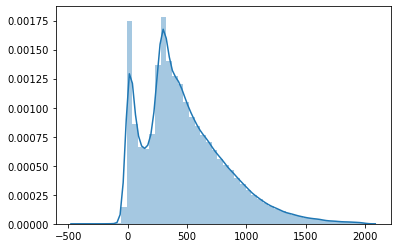

In [41]:
sns.distplot([y for y in Y if y < 2000])

Как можно видеть, наша модель имеет 2 недостатка:
* она не предсказывает экстремально большие значения рейтинга
* она не в полной мере отловила дополнительный пик в малых положительных значениях

Это во многом связано и с простой структурой модели, и с недостатком данных: трудно понять, выйдет ли пост в Горячее, не зная толком его содержания. Разные посты на одну и ту же тематику ведь могут быть оформлены совершенно по-разному. Так что не удивительно, что по таким табличным характеристикам мы не смогли в полной мере предсказать успех поста.

Но давайте посмотрим, насколько хорошо мы предсказываем рейтинг хотя бы "в среднем":

In [42]:
# посчитаем среднюю абсолютную ошибку на наших данных

from sklearn.metrics import mean_absolute_error

In [43]:
mean_absolute_error(Y, Y_pred)

140.2001672030061

In [44]:
# давайте сравним с каким-нибудь бейзлайном
# какая была бы ошибка, если б мы предсказывали просто средним значением?
Y_pred_mean = np.repeat(Y.mean(), len(Y))

mean_absolute_error(Y, Y_pred_mean)

287.9861978214588

Итого, при помощи использования простейшей модели нейросети нам удалось предсказать рейтинг постов в 2 раза точнее, чем если бы мы просто брали среднее значение. При этом нам даже не потребовалось изучать содержание самих постов.

In [45]:
Y.mean()

492.68788203079475